In [1]:
import matplotlib.pyplot as plt
from numpy import *
from qutip import *
from IPython.display import Image
from numpy.linalg import *
#############################################

# definitions

# negativity
def negativity(sigma):
    #Partial transpose of sigma
    sigmapt = partial_transpose(sigma,(0,1))
    #Eigenvalues of Sigmapt
    evals = sigmapt.eigenenergies()
    #Sum of negative eigenvalues
    s = 0
    l = sigma.shape[0]
    for i in range(0,l):
        s = s + abs((evals[i] - abs(evals[i])))
    return s

# prints the simulation parameters
def parameters(n):
    chi_a = ga**2/(wa*wr) 
    chi_b = gb**2/(wb*wr)
    chi_ab = gb*ga/(wa*wr)
    chi_ba = gb*ga/(wb*wr)
    print("# Simulation parameters:")
    print("wa = ", wa)
    print("wb = ", wb)
    print("wr = ", wr)
    print("ga = ", ga)
    print("gb = ", gb)
    print("chi_a = ", chi_a)
    print("chi_b = ", chi_b)
    #print(">IF Fock state, then")
    print("na = ", na,", nb = ", nb, ", nr = ", nr)
    #print(">IF Coherent state, then ")
    #print("alpha_a = ", sqrt(na_avg),", alpha_b = ", sqrt(nb_avg))
    if n > 0:
        # In case of dissipations
        print("kappa_a = ", kappa_a)
        print("kappa_b = ", kappa_b)
        print("gamma = ", gamma)
    return 0

#############################################

# parameters

# frequency related
wa = 1.0 #* 2 * pi    # cavity a frequency
wb = 1.0 #* 2 * pi    # cavity b frequency
wr = 0.5 #* 2 * pi    # mechanical oscilattor frequency
ga  = 0.01            # coupling strength cavity a
gb  = 0.1             # coupling strength cavity b
kappa_a = 0.0         # cavity a dissipation rate
kappa_b = 0.0         # cavity b dissipation rate
gamma = 0.0           # mechanic damping rate

# number related
na = 1
nb = 0
nr = 0
na_avg = 2.5
nb_avg = 0.5

N = 7                # Fock space dimension

n_th_a = 0.0         # avg number of thermal bath excitation coupled to a
n_th_b = 0.0         # avg number of thermal bath excitation coupled to b
n_th_r = 0.0         # avg number of thermal bath excitation coupled to r

# time related
t0 = 0
tf = 250
nt = 700
dt = (tf-t0)/nt
tlist = linspace(t0,tf,nt)

#############################################

# initial state
#state_a_t0 = coherent(N, sqrt(na_avg))
#state_b_t0 = coherent(N, sqrt(nb_avg))
state_a_t0 = fock(N, na)
state_b_t0 = fock(N, nb)
state_r_t0 = fock(N,nr)

state_t0 = tensor(state_a_t0,state_b_t0,state_r_t0)


#############################################

# operators

# annihilation
a  = tensor(destroy(N),qeye(N),qeye(N))
b  = tensor(qeye(N),destroy(N),qeye(N))
r  = tensor(qeye(N),qeye(N),destroy(N))

# number
Na = a.dag() * a
Nb = b.dag() * b
Nr = r.dag() * r

# quadrature X
Xa = a.dag() + a
Xb = b.dag() + b
Xr = r.dag() + r

# operator alpha
alpha = (ga/wr)*Na + (gb/wr)*Nb


#############################################

# Hamiltonian
Hvec = []
#Hvec.append(wa*Na)                           # Field mode a free energy
#Hvec.append(wb*Nb)                           # Field mode b free energy  
Hvec.append(wr*Nr)                            # Mechanical oscilattor energy
Hvec.append(ga*Na*Xr)                        # interaction cavity-a with mechanical osc. (1st order)  
Hvec.append(gb*Nb*Xr)                        # interaction cavity-a with mechanical osc. (1st order)
#Hvec.append(wa*Na*(1+(ga/wa)*alpha))          # interaction cavity-a with mechanical osc. (1st order)   
#Hvec.append(wb*Nb*(1+(gb/wb)*alpha))          # interaction cavity-b with mechanical osc. (1st order)
   
H = 0
for i in range(len(Hvec)):
    H = H + Hvec[i]


#############################################

# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)
    
# Excitations, only temperature > 0   
    
# cavity-a excitation
rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

# cavity-b excitation    
rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())
    
# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())


#############################################

# Master equation solve function

Op_list = []
#Op_list = [Na,Nb,Xa,Xb]
comp = mesolve(H, state_t0, tlist, c_ops, Op_list)

#############################################

# Entanglement measures for N = 2

if N < 3:
    negativity_ab = []  
    negativity_ar = []
    negativity_br = []
    concurrence_ab = []
    concurrence_ar = []
    concurrence_br = []
    for i in range(nt):
        rho_t = comp.states[i]
        rho_ab_t = ptrace(rho_t, [0,1])
        rho_ar_t = ptrace(rho_t, [0,2])
        rho_br_t = ptrace(rho_t, [1,2])
        negativity_ab.append(negativity(rho_ab_t))
        negativity_ar.append(negativity(rho_ar_t))
        negativity_br.append(negativity(rho_br_t))
        concurrence_ab.append(concurrence(rho_ab_t))
        concurrence_ar.append(concurrence(rho_ar_t))
        concurrence_br.append(concurrence(rho_br_t))
    ###### 1st plot ######
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    axes.plot(tlist, (real(negativity_ab)),'b',label= "a-b", lw=2.0)
    axes.plot(tlist, (real(negativity_ar)),'r' ,label= "a-r", lw=2.0)
    axes.plot(tlist, (real(negativity_ar)),'g' ,label= "b-r", lw=2.0)
    axes.legend(loc=0)
    axes.set_ylim(0, 1.01)
    axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
    axes.set_ylabel('Negatividade  $\mathcal{N}$ ',rotation=90,fontsize= 22.0)
    plt.show()
    ###### 2nd plot ######
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    axes.plot(tlist, (real(concurrence_ab)),'b',label= "a-b", lw=2.0)
    axes.plot(tlist, (real(concurrence_ar)),'r' ,label= "a-r", lw=2.0)
    axes.plot(tlist, (real(concurrence_br)),'g' ,label= "b-r", lw=2.0)
    axes.legend(loc=0)
    axes.set_ylim(0, 1.01)
    axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
    axes.set_ylabel('Concurrence  $\mathcal{C}$ ',rotation=90,fontsize= 22.0)
    plt.show()
else:
    print("Error: Invalid system dimensions. The negativity and concurrence cannot be calculated.")
    
#############################################

# Expected values

Na_m = expect(Na, comp.states)
Nb_m = expect(Nb, comp.states)
Nr_m = expect(Nr, comp.states)

Xa_m = expect(Xa, comp.states)
Xb_m = expect(Xb, comp.states)
Xr_m = expect(Xr, comp.states)

Na_m_sqrd = expect(Na*Na, comp.states)
Nb_m_sqrd = expect(Nb*Nb, comp.states)

parameters(0)
###### 1st plot ######
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, (real(Na_m)),'b',label= "$N_a$", lw=3.0)
axes.plot(tlist, (real(Nb_m)),'r--' ,label= "$N_b$", lw=3.0)
axes.plot(tlist, (real(Nr_m)),'g' ,label= "$N_r$", lw=3.0)
axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Avg photon number',rotation=90,fontsize= 22.0)
plt.show()
###### 2nd plot ######
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, (real(Na_m_sqrd)),'b',label= "$N_a^2$", lw=3.0)
axes.plot(tlist, (real(Nb_m_sqrd)),'r--' ,label= "$N_b^2$", lw=3.0)
axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Avg photon number squared',rotation=90,fontsize= 22.0)
plt.show()

###### 3rd plot ######
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, (real(Xa_m)),'b',label= "$X_a$", lw=2.0)
axes.plot(tlist, (real(Xb_m)),'r' ,label= "$X_b$", lw=2.0)
axes.plot(tlist, (real(Xr_m)),'g' ,label= "$X_r$", lw=2.0)
axes.legend(loc=0)
#axes.set_ylim(-4, 4)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Avg quadrature X',rotation=90,fontsize= 22.0)
plt.show()
    
#############################################


Error: Invalid system dimensions. The negativity and concurrence cannot be calculated.
# Simulation parameters:
wa =  1.0
wb =  1.0
wr =  0.5
ga =  0.01
gb =  0.1
chi_a =  0.0002
chi_b =  0.020000000000000004
na =  1 , nb =  0 , nr =  0


# Simulation parameters:
wa =  1.0
wb =  1.0
wr =  0.2
ga =  0.01
gb =  0.1
chi_a =  0.0005
chi_b =  0.05000000000000001
>IF Fock state, then
na =  1 , nb =  2 , nr =  0
>IF Coherent state, then 
alpha_a =  1.5811388300841898 , alpha_b =  0.7071067811865476


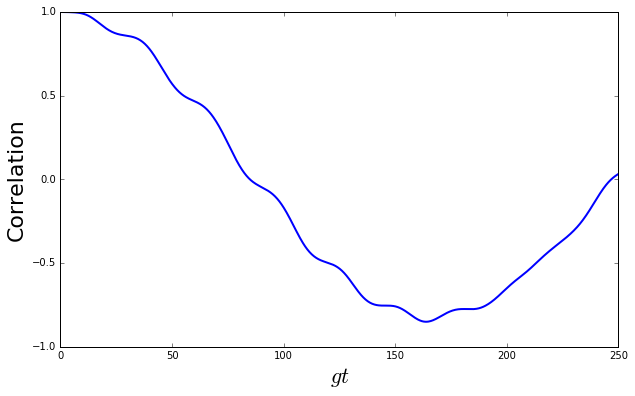

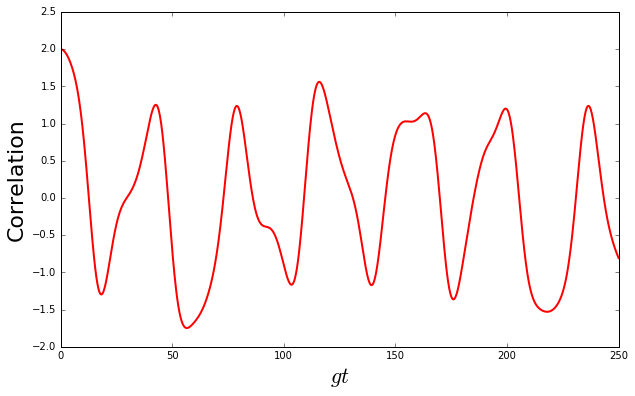

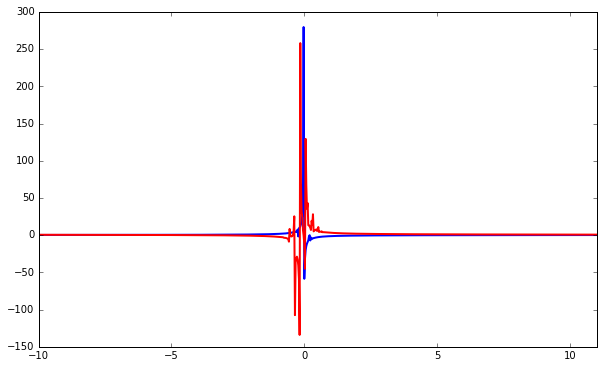

In [132]:
# Correlation 

tlist2 = linspace(t0,tf,1000)
corr_a = correlation_2op_2t(H, state_t0, None, tlist2, [],  a.dag(), a)
corr_b = correlation_2op_2t(H, state_t0, None, tlist2, [],  b.dag(), b)


wlist1, Sa = spectrum_correlation_fft(tlist2, corr_a)
wlist2, Sb = spectrum_correlation_fft(tlist2, corr_b)

parameters(0)

##########
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist2, (real(corr_a)),'b', lw=2.0)
#axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
plt.show()
##########
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist2, (real(corr_b)),'r', lw=2.0)
#axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
plt.show()
##########
parameters(0)
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(wlist1, (real(Sa)),'b', lw=2.0)
axes.plot(wlist2, (real(Sb)),'r', lw=2.0)
#axes.legend(loc=0)
#axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
#axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
axes.set_xlim(-10, 11)
plt.show()

# Simulation parameters:
wa =  1.0
wb =  1.0
wr =  0.2
ga =  0.01
gb =  0.1
chi_a =  0.0005
chi_b =  0.05000000000000001
>IF Fock state, then
na =  1 , nb =  2 , nr =  0
>IF Coherent state, then 
alpha_a =  1.5811388300841898 , alpha_b =  0.7071067811865476


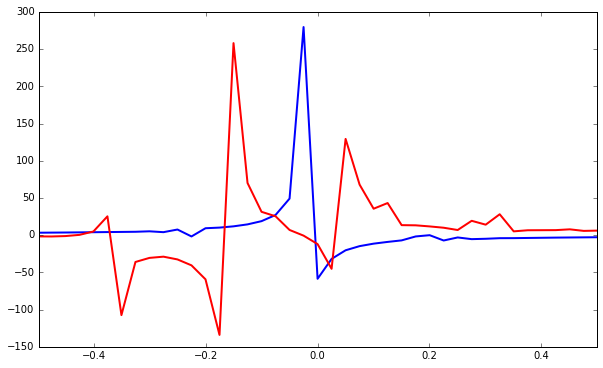

In [135]:
parameters(0)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(wlist1, (real(Sa)),'b', lw=2.0)
axes.plot(wlist2, (real(Sb)),'r', lw=2.0)
#axes.legend(loc=0)
#axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
#axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
axes.set_xlim(-0.5, 0.5)
plt.show()

# Simulation parameters:
wa =  1.0
wb =  1.0
wr =  0.2
ga =  0.01
gb =  0.1
chi_a =  0.0005
chi_b =  0.05000000000000001
>IF Fock state, then
na =  1 , nb =  2 , nr =  0
>IF Coherent state, then 
alpha_a =  1.5811388300841898 , alpha_b =  0.7071067811865476


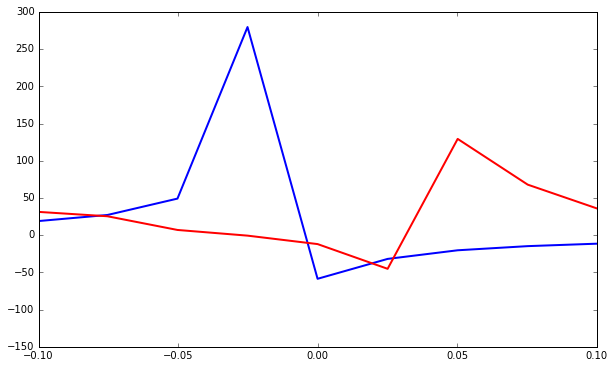

In [136]:
parameters(0)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(wlist1, (real(Sa)),'b', lw=2.0)
axes.plot(wlist2, (real(Sb)),'r', lw=2.0)
#axes.legend(loc=0)
#axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
#axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
axes.set_xlim(-0.1, 0.1)
plt.show()

In [91]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.1
Numpy,1.16.2
SciPy,1.3.1
matplotlib,1.5.1
Cython,0.25.2
Number of CPUs,12
BLAS Info,OPENBLAS
IPython,6.1.0
Python,"3.5.2 (default, Sep 10 2016, 08:21:44) [GCC 5.4.0 20160609]"
OS,posix [linux]
